In [1]:
# -*- coding: utf-8 -*-
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, schedule, transpiler
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.tools import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.visualization import timeline_drawer
from qiskit.visualization.timeline import draw, IQXSimple, IQXStandard

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Import measurement calibration functions
from qiskit.ignis.mitigation import MeasurementFilter
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

# For data fitting
from lmfit import Model

C:\Users\usuario\AppData\Local\Temp\ipykernel_3164\2715227163.py:18: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation import MeasurementFilter


In [3]:
provider = IBMQ.enable_account('account-id-here')
#provider = IBMQ.load_account()

In [4]:
backend = provider.get_backend('ibmq_lima')
backend

<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>

## Get gates duration
https://qiskit.org/documentation/stubs/qiskit.transpiler.InstructionDurations.get.html
https://qiskit.org/documentation/tutorials/circuits_advanced/08_gathering_system_information.

In [5]:
# Get duration of instructions

dt_in_s = backend.configuration().dt
Reset_duration = transpiler.InstructionDurations.from_backend(backend).get("reset",0)
I_duration     = transpiler.InstructionDurations.from_backend(backend).get("id",3)
Z_duration     = transpiler.InstructionDurations.from_backend(backend).get("rz",0)
SX_duration    = transpiler.InstructionDurations.from_backend(backend).get("sx",1)
X_duration     = transpiler.InstructionDurations.from_backend(backend).get("x",1)
Y_duration     = 3*Z_duration + 2*SX_duration
H_duration     = 2*Z_duration + SX_duration
Measurement_duration = transpiler.InstructionDurations.from_backend(backend).get("measure",1)
Measurement_duration3 = transpiler.InstructionDurations.from_backend(backend).get("measure",3)

CNOT_durations = [] # Will be in dt units
for pair in backend.configuration().coupling_map:
    CNOT_pair_duration = transpiler.InstructionDurations.from_backend(backend).get("cx",pair)
    CNOT_durations.append([str(pair),CNOT_pair_duration])
CNOT_durations = dict(CNOT_durations)

tau_cnot01 = CNOT_durations["[0, 1]"]
tau_cnot10 = CNOT_durations["[1, 0]"]
tau_cnot34 = CNOT_durations["[3, 4]"]
tau_cnot43 = CNOT_durations["[4, 3]"]
tau_cnot13 = CNOT_durations["[1, 3]"]
tau_cnot31 = CNOT_durations["[3, 1]"]

## Calibration
See https://github.com/Qiskit/qiskit-ignis#creating-your-first-quantum-experiment-with-qiskit-ignis

Generate the measurement calibration circuits for running measurement error mitigation:

In [89]:
qr = QuantumRegister(5)
meas_cals, state_labels = complete_meas_cal(qubit_list=[1,3], qr=qr)
tr_meas_cals = transpile(meas_cals, backend=backend, scheduling_method='asap', optimization_level=0)

Send the calibration job:

In [90]:
job_manager = IBMQJobManager()
job = job_manager.run(tr_meas_cals, backend=backend, name='calibration-8192shots-q1q3', shots=8192)

In [ ]:
job.statuses()

Get the calibration results:

In [93]:
cal_results = job.results().combine_results()

# Make a calibration matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

# Create a measurement filter from the calibration matrix
meas_filter = meas_fitter.filter

In [94]:
calMatrix = meas_fitter.cal_matrix
calMatrix

array([[0.99255371, 0.1114502 ],
       [0.00744629, 0.8885498 ]])

In [9]:
# M^{-1}_{1,3}
calMatrix = np.array([[9.75708008e-01, 3.50341797e-02, 6.53076172e-02, 2.19726562e-03],
                      [9.88769531e-03, 9.54101562e-01, 8.54492188e-04, 6.45751953e-02],
                      [1.41601562e-02, 4.88281250e-04, 9.24804688e-01, 3.56445312e-02],
                      [2.44140625e-04, 1.03759766e-02, 9.03320312e-03, 8.97583008e-01]])

For building a filter from a calibration matrix already stored:

In [7]:
stateLabels = ["00", "01", "10", "11"]

from qiskit.ignis.mitigation import MeasurementFilter
meas_filter = MeasurementFilter(calMatrix, stateLabels)
meas_filter.cal_matrix

array([[9.75708008e-01, 3.50341797e-02, 6.53076172e-02, 2.19726562e-03],
       [9.88769531e-03, 9.54101562e-01, 8.54492188e-04, 6.45751953e-02],
       [1.41601562e-02, 4.88281250e-04, 9.24804688e-01, 3.56445312e-02],
       [2.44140625e-04, 1.03759766e-02, 9.03320312e-03, 8.97583008e-01]])

In [10]:
# For printing in LaTeX format

def bmatrix(a):
    """Returns a LaTeX bmatrix
    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += [('  ' + ' & '.join(l.split()) + r'\\').replace('e',r' \times 10^{').replace(" &", "} &").replace(r"\\", r"} \\") for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

print(bmatrix(calMatrix))

\begin{bmatrix}
  9.75708008 \times 10^{-01} & 3.50341797 \times 10^{-02} & 6.53076172 \times 10^{-02} & 2.19726562 \times 10^{-03} \\
  9.88769531 \times 10^{-03} & 9.54101562 \times 10^{-01} & 8.54492188 \times 10^{-04} & 6.45751953 \times 10^{-02} \\
  1.41601562 \times 10^{-02} & 4.88281250 \times 10^{-04} & 9.24804688 \times 10^{-01} & 3.56445312 \times 10^{-02} \\
  2.44140625 \times 10^{-04} & 1.03759766 \times 10^{-02} & 9.03320312 \times 10^{-03} & 8.97583008 \times 10^{-01} \\
\end{bmatrix}


## Define the circuit creation functions

XYXY sequence:

In [11]:
def get_protocol_transpiled_circuit(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=[1,0], wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True):

    tau_block = 2*(X_duration+Y_duration)                                      # Time duration of a XYXY block.
    tau_data  = bell_state[0]*X_duration + H_duration + tau_cnot13             # Time duration of the Bell pair creation gate.
    tau_swap  = 2*tau_cnot34 + tau_cnot43                                      # Time duration of the slowest swap gate.
    tau_wait  = num_blocks*tau_block                                           # Time duration of the wait period.
    tau_diff  = abs((2*tau_cnot01 + tau_cnot10) - (2*tau_cnot34 + tau_cnot43)) # Difference between the duration of the swap gate on qubits 0 & 1 and the swap gate on qubits 3 & 4.
    tau_meas  = Measurement_duration                                           # Time duration of the measurement gate.
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas                  # Total time duration of the whole circuit.
    
    # Create the registers.
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Preventive reset.
    circuit.reset(reset_qubits)
    
    # Data gate (Bell pair creation gate).
    if bell_state[0] == 1:
        circuit.x(1)
    if bell_state[1] == 1:
        circuit.x(3)
    circuit.h(1)
    circuit.cnot(1,3)

    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    wait_duration = 0
    if DD_wait == True: # Apply DD to the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.x(wait_DD_qubits)
            circuit.y(wait_DD_qubits)
            circuit.x(wait_DD_qubits)
            circuit.y(wait_DD_qubits)
    elif DD_wait == False: # Do nothing during the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)

    if DD_diff == True: # Apply DD to the after second swap part
        if DD_wait == True:
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.x(diff_DD_qubits)
                circuit.y(diff_DD_qubits)
                circuit.x(diff_DD_qubits)
                circuit.y(diff_DD_qubits)
        elif DD_wait == False: # Do nothing, wait too
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
        
    # Second swap gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    # Inverse data gate (Bell pair decodification gate).
    circuit.cnot(1,3)
    circuit.h(1)
    if bell_state[1] == 1:
        circuit.x(3)
    if bell_state[0] == 1:
        circuit.x(1)
    
    # Measure.
    circuit.measure(1,0)
    circuit.measure(3,1)
    
    # Transpile the circuit.
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return tcircuit, wait_duration

XZXZ sequence:

In [12]:
# XZXZ
def get_protocol_transpiled_circuit_XZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=[1,0], wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True):

    tau_block = 2*X_duration                                                   # Time duration of a XZXZ block.
    tau_data  = bell_state[0]*X_duration + H_duration + tau_cnot13             # Time duration of the Bell pair creation gate.
    tau_swap  = 2*tau_cnot34 + tau_cnot43                                      # Time duration of the slowest swap gate.
    tau_wait  = num_blocks*tau_block                                           # Time duration of the wait period.
    tau_diff  = abs((2*tau_cnot01 + tau_cnot10) - (2*tau_cnot34 + tau_cnot43)) # Difference between the duration of the swap gate on qubits 0 & 1 and the swap gate on qubits 3 & 4.
    tau_meas  = Measurement_duration                                           # Time duration of the measurement gate.
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas                  # Total time duration of the whole circuit.
    
    # Create the registers.
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Preventive reset.
    circuit.reset(reset_qubits)
  
    # Data gate (Bell pair creation gate).
    if bell_state[0] == 1:
        circuit.x(1)
    if bell_state[1] == 1:
        circuit.x(3)
    circuit.h(1)
    circuit.cnot(1,3)

    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    wait_duration = 0
    if DD_wait == True: # Apply DD to the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.x(wait_DD_qubits)
            circuit.z(wait_DD_qubits)
            circuit.x(wait_DD_qubits)
            circuit.z(wait_DD_qubits)
    elif DD_wait == False: # Do nothing during the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)

    if DD_diff == True: # Apply DD to the after second swap part
        if DD_wait == True:
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.x(diff_DD_qubits)
                circuit.z(diff_DD_qubits)
                circuit.x(diff_DD_qubits)
                circuit.z(diff_DD_qubits)
        elif DD_wait == False: # Do nothing, wait too
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
        
    # Second swap gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    # Inverse data gate (Bell pair decodification gate).
    circuit.cnot(1,3)
    circuit.h(1)
    if bell_state[1] == 1:
        circuit.x(3)
    if bell_state[0] == 1:
        circuit.x(1)
    
    # Measure.
    circuit.measure(1,0)
    circuit.measure(3,1)
    
    # Transpile the circuit.
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return tcircuit, wait_duration

YZYZ sequence:

In [13]:
# YZYZ
def get_protocol_transpiled_circuit_YZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=[1,0], wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True):

    tau_block = 2*Y_duration                                                   # Time duration of a YZYZ block.
    tau_data  = bell_state[0]*X_duration + H_duration + tau_cnot13             # Time duration of the Bell pair creation gate.
    tau_swap  = 2*tau_cnot34 + tau_cnot43                                      # Time duration of the slowest swap gate.
    tau_wait  = num_blocks*tau_block                                           # Time duration of the wait period.
    tau_diff  = abs((2*tau_cnot01 + tau_cnot10) - (2*tau_cnot34 + tau_cnot43)) # Difference between the duration of the swap gate on qubits 0 & 1 and the swap gate on qubits 3 & 4.
    tau_meas  = Measurement_duration                                           # Time duration of the measurement gate.
    tau_total = 2*tau_data + 2*tau_swap + tau_wait + tau_meas                  # Total time duration of the whole circuit.
    
    # Create the registers.
    q  = QuantumRegister(5, 'q')
    c  = ClassicalRegister(2, 'c')
    circuit = QuantumCircuit(q, c)
    
    # Preventive reset.
    circuit.reset(reset_qubits)

    # Data gate (Bell pair creation gate).
    if bell_state[0] == 1:
        circuit.x(1)
    if bell_state[1] == 1:
        circuit.x(3)
    circuit.h(1)
    circuit.cnot(1,3)

    # First SWAP gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    wait_duration = 0
    if DD_wait == True: # Apply DD to the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.y(wait_DD_qubits)
            circuit.z(wait_DD_qubits)
            circuit.y(wait_DD_qubits)
            circuit.z(wait_DD_qubits)
    elif DD_wait == False: # Do nothing during the waiting part
        wait_duration = tau_wait*dt_in_s*1e6
        #print("Wait duration =", wait_duration, "us")
        for i in range(num_blocks):
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)
            circuit.id(wait_DD_qubits)

    if DD_diff == True: # Apply DD to the after second swap part
        if DD_wait == True:
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.y(diff_DD_qubits)
                circuit.z(diff_DD_qubits)
                circuit.y(diff_DD_qubits)
                circuit.z(diff_DD_qubits)
        elif DD_wait == False: # Do nothing, wait too
            num_blocks_end = int(2*tau_diff/tau_block)
            for i in range(num_blocks_end):
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)
                circuit.id(diff_DD_qubits)                
        
    # Second swap gates.
    circuit.cnot(0,1)
    circuit.cnot(1,0)
    circuit.cnot(0,1)
    circuit.cnot(3,4)
    circuit.cnot(4,3)
    circuit.cnot(3,4)

    # Inverse data gate (Bell pair decodification gate).
    circuit.cnot(1,3)
    circuit.h(1)
    if bell_state[1] == 1:
        circuit.x(3)
    if bell_state[0] == 1:
        circuit.x(1)
  
    # Measure.
    circuit.measure(1,0)
    circuit.measure(3,1)
    
    # Transpile the circuit.
    tcircuit = transpile(circuit, backend=backend, scheduling_method='alap', optimization_level=0)
    
    return tcircuit, wait_duration

**Circuit building settings.**

In [14]:
max_time   = 15 # In us.
num_steps  = 15 
wait_times = np.linspace(0, max_time, num_steps) # In us.
#print(wait_times)

num_blocks_array    = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # Number of blocks necessary to fit the wait times.
num_blocks_array_XY = ((wait_times*1e-6/dt_in_s)/(2*(X_duration + Y_duration))).astype(int) # For the XYXY case
num_blocks_array_XZ = ((wait_times*1e-6/dt_in_s)/(2*X_duration)).astype(int)                # For the XZXZ case
num_blocks_array_YZ = ((wait_times*1e-6/dt_in_s)/(2*Y_duration)).astype(int)                # For the YZYZ case
#print(num_blocks_array_XY, num_blocks_array_XZ, num_blocks_array_YZ)
#print(num_blocks_array, num_steps*4*2, num_steps==len(num_blocks_array))
#print(4*num_blocks_array)

shots = 2**13
#print(shots)

bell_states = [[0,0], [0,1], [1,0], [1,1]]
repetitions = 10

reshape_dims = (len(bell_states), repetitions, 4, num_steps)
#print(reshape_dims)
#print("Total number of circuits:", np.prod(reshape_dims))

## Build the circuits

In [ ]:
all_wait_times = []
all_counts = []
all_transpiled_circuits = []

"""
Data format: [[[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β00>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β01>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β10>,
              [[XYXY case, XZXZ case, YZYZ case, IIII case], repetitions...] for |β11>]
"""

for i, bell_state in enumerate(bell_states): # Prepare all the circuits.

    repetitions_counts = []
    repetitions_wait_times = []
    
    wait_times_XYXY = []
    wait_times_XZXZ = []
    wait_times_YZYZ = []
    wait_times_IIII = []
    transpiled_circuits_XYXY = []
    transpiled_circuits_XZXZ = []
    transpiled_circuits_YZYZ = []
    transpiled_circuits_IIII = []
    
    state_transpiled_circuits = []

    print("Bell state:", bell_state)
    print("Generating the XYXY circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XY): # Build the XYXY circuits.
        print("\tXYXY", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=bell_state, wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True)
        wait_times_XYXY.append(wait_time)
        transpiled_circuits_XYXY.append(tcircuit)
        
    print("Generating the XZXZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_XZ): # Build the XZXZ circuits.
        print("\tXZXZ", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit_XZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=bell_state, wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True)
        wait_times_XZXZ.append(wait_time)
        transpiled_circuits_XZXZ.append(tcircuit)
        
    print("Generating the YZYZ circuits...")
    for j, num_blocks in enumerate(num_blocks_array_YZ): # Build the XZXZ circuits.
        print("\tYZYZ", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit_YZ(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=bell_state, wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=True, DD_diff=True)
        wait_times_YZYZ.append(wait_time)
        transpiled_circuits_YZYZ.append(tcircuit)
        
    print("Generating the IIII circuits...")
    for j, num_blocks in enumerate(num_blocks_array): # Build the IIII circuits.
        print("\tIIII", i, j+1, num_steps)
        tcircuit, wait_time = get_protocol_transpiled_circuit(num_blocks, backend, 
                                    X_duration, Y_duration, H_duration, Measurement_duration,
                                    tau_cnot01, tau_cnot10, tau_cnot13, tau_cnot34, tau_cnot43,
                                    bell_state=bell_state, wait_DD_qubits=[0,4], diff_DD_qubits=[0], reset_qubits=[0,1,3,4],
                                    DD_wait=False, DD_diff=True)
        wait_times_IIII.append(wait_time)
        transpiled_circuits_IIII.append(tcircuit)

    state_transpiled_circuits.append([transpiled_circuits_XYXY, transpiled_circuits_XZXZ, transpiled_circuits_YZYZ, transpiled_circuits_IIII])
    all_wait_times.append([wait_times_XYXY, wait_times_XZXZ, wait_times_YZYZ, wait_times_IIII])
    
    # Flatten the transpiled circuits to send them in a single job
    circuits_array = np.asarray(state_transpiled_circuits) # Get a 2D array containing the set of circuits for each sequence.
    dimensions = np.shape(circuits_array) # Get the dimensions of the 2D array.
    circuits_array_flattened = circuits_array.flatten() # Make the array 1-dimensional.
    #print("Number of circuits:", len(circuits_array_flattened))
    
    print("Building repetitions...")
    for j in range(repetitions):
        print("\tRepetition",j)
        all_transpiled_circuits = all_transpiled_circuits + circuits_array_flattened.tolist()

    print("Done!")
print("Finished!")

### Plot a circuit schedule to look for errors.

In [16]:
# Instruction durations for the schedule plot

durations = InstructionDurations(
    [("h", 1, H_duration), 
     ("x", 0, X_duration), 
     ("x", 1, X_duration), 
     ("x", 2, X_duration), 
     ("x", 3, X_duration), 
     ("x", 4, X_duration), 
     ("z", 0, Z_duration), 
     ("z", 1, Z_duration), 
     ("z", 2, Z_duration), 
     ("z", 3, Z_duration), 
     ("z", 4, Z_duration),
     ("id", 0, I_duration),
     ("id", 1, I_duration),
     ("id", 2, I_duration),
     ("id", 3, I_duration),
     ("id", 4, I_duration),
     ("cx", [0, 1], CNOT_durations["[0, 1]"]), 
     ("cx", [1, 0], CNOT_durations["[1, 0]"]),
     ("cx", [1, 3], CNOT_durations["[1, 3]"]),
     ("cx", [3, 4], CNOT_durations["[3, 4]"]),
     ("cx", [4, 3], CNOT_durations["[4, 3]"]),
     ("reset", None, Reset_duration),
     ("measure", None, Measurement_duration)]
)

pm = PassManager([ALAPSchedule(durations)])

In [17]:
# Style for the schedule plot

# https://matplotlib.org/3.5.0/users/prev_whats_new/dflt_style_changes.html
# https://qiskit.org/documentation/stubs/qiskit.visualization.timeline_drawer.html
# https://github.com/Qiskit/qiskit-terra/pull/5063/files/5fa5898bad0a53da23c0daa61f2d99c7e822de1b#diff-4ad47bcead055d747c1ef626ff0baece4907ef6e8ee6a227c9df53459ca9ea86

my_style = {
    "formatter.latex_symbol.frame_change" : r"\,",
    'formatter.general.fig_width': 20,
    #"formatter.unicode_symbol.frame_change" : "",
    #"formatter.layer.frame_change" : 0,
    #"formatter.text_size.frame_change":0,
    #"formatter.alpha.gates":0,
    "formatter.text_size.gate_name": 14,
    "formatter.time_bucket.edge_dt": 100,
    "formatter.latex_symbol.gates":
        {
        'rz': r'\,',
        'x': r'\,',
        'sx': r'\,',
        'id': r'\,',
        'reset': r'|0\rangle',
        'measure': r'{\rm Measure}'
        },
    "formatter.color.gates":
        {
        'cx': '#6FA4FF',
        'x': '#DC143C',
        'sx': '#DC143C',
        'reset': '#a0a0a0',
        'measure': '#a0a0a0' #'#808080',
        #'delay': '#1E90FF'
        }
}

style = IQXStandard(**my_style)

C:\Users\usuario\AppData\Local\Temp\ipykernel_3164\3239185454.py:1: FutureWarning: The input object of type 'Delay' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Delay', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][0][2] # [state][repetition][sequence type][num_blocks index]
C:\Users\usuario\AppData\Local\Temp\ipykernel_3164\3239185454.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

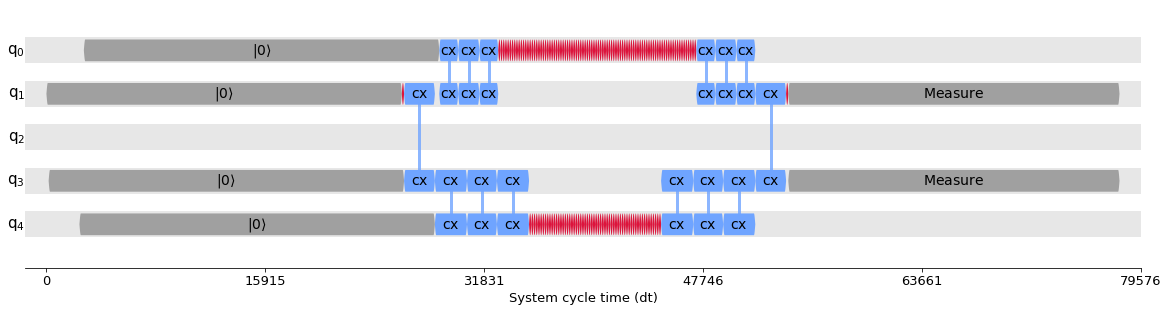

In [18]:
sample_circuit = np.asarray(all_transpiled_circuits).reshape(reshape_dims)[0][0][0][2] # [state][repetition][sequence type][num_blocks index]
timeline_drawer(sample_circuit, style=style)#, show_delays=True)

## Send the job set to IBM

In [48]:
job_manager = IBMQJobManager()
job_set = job_manager.run(all_transpiled_circuits, backend=backend, name='XYXY-XZXZ-YZYZ-IIII-BellStates-errorBars-8192shots-15us-15steps-10reps', shots=shots)
#job_monitor(job_set)

managedjob._async_submit:WARNING:2022-08-13 02:29:33,108: Job limit reached, waiting for job 62f6ebc00f71a1bfa3860f5a to finish before submitting the next one.


**For saving the job_set id for being able to retrieve it in the future.**

In [ ]:
job_set_id = job_set.job_set_id()
print(job_set_id)

**For checking the job status, etc.**

In [ ]:
job_set.statuses()
#job_set.cancel ()
#job_set.error_messages()

**For retrieving past job sets.**

In [17]:
job_manager = IBMQJobManager()
job_set = job_manager.retrieve_job_set("put-the-job_set-id-here", provider)

## Get the job results

In [ ]:
results = job_set.results()

In [19]:
all_counts_array = np.array([results.get_counts(i) for i in range(len(all_transpiled_circuits))])

**For measurement error mitigation:**

In [28]:
all_counts_array_mit = np.asarray([meas_filter.apply(all_counts_array[i]) for i in range(len(all_counts_array))])

In [29]:
all_counts_array = all_counts_array_mit

## Get the counts

Get the raw counts

In [21]:
counts00_bell00_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[0][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[0][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[0][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell00_IIII = np.array([[all_counts_array.reshape(reshape_dims)[0][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell01_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[1][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[1][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[1][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell01_IIII = np.array([[all_counts_array.reshape(reshape_dims)[1][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell10_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[2][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[2][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[2][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell10_IIII = np.array([[all_counts_array.reshape(reshape_dims)[2][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

counts00_bell11_XYXY = np.array([[all_counts_array.reshape(reshape_dims)[3][i][0][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_XZXZ = np.array([[all_counts_array.reshape(reshape_dims)[3][i][1][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_YZYZ = np.array([[all_counts_array.reshape(reshape_dims)[3][i][2][j]["00"] for j in range(num_steps)] for i in range(repetitions)])
counts00_bell11_IIII = np.array([[all_counts_array.reshape(reshape_dims)[3][i][3][j]["00"] for j in range(num_steps)] for i in range(repetitions)])

raw_counts00 = [[counts00_bell00_XYXY, counts00_bell00_XZXZ, counts00_bell00_YZYZ, counts00_bell00_IIII],
                [counts00_bell01_XYXY, counts00_bell01_XZXZ, counts00_bell01_YZYZ, counts00_bell01_IIII],
                [counts00_bell10_XYXY, counts00_bell10_XZXZ, counts00_bell10_YZYZ, counts00_bell10_IIII],
                [counts00_bell11_XYXY, counts00_bell11_XZXZ, counts00_bell11_YZYZ, counts00_bell11_IIII]]

Get the average of the repetitions

In [23]:
avg_counts00_bell00_XYXY = np.round(np.average(counts00_bell00_XYXY, axis=0)).astype(int)
avg_counts00_bell00_XZXZ = np.round(np.average(counts00_bell00_XZXZ, axis=0)).astype(int)
avg_counts00_bell00_YZYZ = np.round(np.average(counts00_bell00_YZYZ, axis=0)).astype(int)
avg_counts00_bell00_IIII = np.round(np.average(counts00_bell00_IIII, axis=0)).astype(int)

avg_counts00_bell01_XYXY = np.round(np.average(counts00_bell01_XYXY, axis=0)).astype(int)
avg_counts00_bell01_XZXZ = np.round(np.average(counts00_bell01_XZXZ, axis=0)).astype(int)
avg_counts00_bell01_YZYZ = np.round(np.average(counts00_bell01_YZYZ, axis=0)).astype(int)
avg_counts00_bell01_IIII = np.round(np.average(counts00_bell01_IIII, axis=0)).astype(int)

avg_counts00_bell10_XYXY = np.round(np.average(counts00_bell10_XYXY, axis=0)).astype(int)
avg_counts00_bell10_XZXZ = np.round(np.average(counts00_bell10_XZXZ, axis=0)).astype(int)
avg_counts00_bell10_YZYZ = np.round(np.average(counts00_bell10_YZYZ, axis=0)).astype(int)
avg_counts00_bell10_IIII = np.round(np.average(counts00_bell10_IIII, axis=0)).astype(int)

avg_counts00_bell11_XYXY = np.round(np.average(counts00_bell11_XYXY, axis=0)).astype(int)
avg_counts00_bell11_XZXZ = np.round(np.average(counts00_bell11_XZXZ, axis=0)).astype(int)
avg_counts00_bell11_YZYZ = np.round(np.average(counts00_bell11_YZYZ, axis=0)).astype(int)
avg_counts00_bell11_IIII = np.round(np.average(counts00_bell11_IIII, axis=0)).astype(int)

avg_counts00 = [[avg_counts00_bell00_XYXY, avg_counts00_bell00_XZXZ, avg_counts00_bell00_YZYZ, avg_counts00_bell00_IIII],
                [avg_counts00_bell01_XYXY, avg_counts00_bell01_XZXZ, avg_counts00_bell01_YZYZ, avg_counts00_bell01_IIII],
                [avg_counts00_bell10_XYXY, avg_counts00_bell10_XZXZ, avg_counts00_bell10_YZYZ, avg_counts00_bell10_IIII],
                [avg_counts00_bell11_XYXY, avg_counts00_bell11_XZXZ, avg_counts00_bell11_YZYZ, avg_counts00_bell11_IIII]]

Get the maximum count values of the repetitions

In [24]:
max_counts00_bell00_XYXY = np.max(counts00_bell00_XYXY, axis=0)
max_counts00_bell00_XZXZ = np.max(counts00_bell00_XZXZ, axis=0)
max_counts00_bell00_YZYZ = np.max(counts00_bell00_YZYZ, axis=0)
max_counts00_bell00_IIII = np.max(counts00_bell00_IIII, axis=0)

max_counts00_bell01_XYXY = np.max(counts00_bell01_XYXY, axis=0)
max_counts00_bell01_XZXZ = np.max(counts00_bell01_XZXZ, axis=0)
max_counts00_bell01_YZYZ = np.max(counts00_bell01_YZYZ, axis=0)
max_counts00_bell01_IIII = np.max(counts00_bell01_IIII, axis=0)

max_counts00_bell10_XYXY = np.max(counts00_bell10_XYXY, axis=0)
max_counts00_bell10_XZXZ = np.max(counts00_bell10_XZXZ, axis=0)
max_counts00_bell10_YZYZ = np.max(counts00_bell10_YZYZ, axis=0)
max_counts00_bell10_IIII = np.max(counts00_bell10_IIII, axis=0)

max_counts00_bell11_XYXY = np.max(counts00_bell11_XYXY, axis=0)
max_counts00_bell11_XZXZ = np.max(counts00_bell11_XZXZ, axis=0)
max_counts00_bell11_YZYZ = np.max(counts00_bell11_YZYZ, axis=0)
max_counts00_bell11_IIII = np.max(counts00_bell11_IIII, axis=0)

max_counts00 = [[max_counts00_bell00_XYXY, max_counts00_bell00_XZXZ, max_counts00_bell00_YZYZ, max_counts00_bell00_IIII],
                [max_counts00_bell01_XYXY, max_counts00_bell01_XZXZ, max_counts00_bell01_YZYZ, max_counts00_bell01_IIII],
                [max_counts00_bell10_XYXY, max_counts00_bell10_XZXZ, max_counts00_bell10_YZYZ, max_counts00_bell10_IIII],
                [max_counts00_bell11_XYXY, max_counts00_bell11_XZXZ, max_counts00_bell11_YZYZ, max_counts00_bell11_IIII]]

Get the minimum count values of the repetitions

In [25]:
min_counts00_bell00_XYXY = np.min(counts00_bell00_XYXY, axis=0)
min_counts00_bell00_XZXZ = np.min(counts00_bell00_XZXZ, axis=0)
min_counts00_bell00_YZYZ = np.min(counts00_bell00_YZYZ, axis=0)
min_counts00_bell00_IIII = np.min(counts00_bell00_IIII, axis=0)

min_counts00_bell01_XYXY = np.min(counts00_bell01_XYXY, axis=0)
min_counts00_bell01_XZXZ = np.min(counts00_bell01_XZXZ, axis=0)
min_counts00_bell01_YZYZ = np.min(counts00_bell01_YZYZ, axis=0)
min_counts00_bell01_IIII = np.min(counts00_bell01_IIII, axis=0)

min_counts00_bell10_XYXY = np.min(counts00_bell10_XYXY, axis=0)
min_counts00_bell10_XZXZ = np.min(counts00_bell10_XZXZ, axis=0)
min_counts00_bell10_YZYZ = np.min(counts00_bell10_YZYZ, axis=0)
min_counts00_bell10_IIII = np.min(counts00_bell10_IIII, axis=0)

min_counts00_bell11_XYXY = np.min(counts00_bell11_XYXY, axis=0)
min_counts00_bell11_XZXZ = np.min(counts00_bell11_XZXZ, axis=0)
min_counts00_bell11_YZYZ = np.min(counts00_bell11_YZYZ, axis=0)
min_counts00_bell11_IIII = np.min(counts00_bell11_IIII, axis=0)

min_counts00 = [[min_counts00_bell00_XYXY, min_counts00_bell00_XZXZ, min_counts00_bell00_YZYZ, min_counts00_bell00_IIII],
                [min_counts00_bell01_XYXY, min_counts00_bell01_XZXZ, min_counts00_bell01_YZYZ, min_counts00_bell01_IIII],
                [min_counts00_bell10_XYXY, min_counts00_bell10_XZXZ, min_counts00_bell10_YZYZ, min_counts00_bell10_IIII],
                [min_counts00_bell11_XYXY, min_counts00_bell11_XZXZ, min_counts00_bell11_YZYZ, min_counts00_bell11_IIII]]

## Plot the results

**Plot the raw data without mitigation or shifting:**

0 0 <Parameter 'T', value=48.49879147991411 +/- 0.932, bounds=[0:inf]>
    <Parameter 'C', value=-0.20687256834690376 +/- 0.00275, bounds=[-inf:inf]>
0 1 <Parameter 'T', value=30.42858849275537 +/- 0.737, bounds=[0:inf]>
    <Parameter 'C', value=-0.1997421831285977 +/- 0.00482, bounds=[-inf:inf]>
0 2 <Parameter 'T', value=24.301181704432686 +/- 0.961, bounds=[0:inf]>
    <Parameter 'C', value=-0.20104996344433082 +/- 0.00899, bounds=[-inf:inf]>
0 3 <Parameter 'T', value=22.140554187929766 +/- 1.73, bounds=[0:inf]>
    <Parameter 'C', value=-0.21542449184664622 +/- 0.0187, bounds=[-inf:inf]>
1 0 <Parameter 'T', value=45.91827738341769 +/- 0.919, bounds=[0:inf]>
    <Parameter 'C', value=-0.19627697757757695 +/- 0.00298, bounds=[-inf:inf]>
1 1 <Parameter 'T', value=34.19740131718887 +/- 0.864, bounds=[0:inf]>
    <Parameter 'C', value=-0.1961076060183442 +/- 0.00466, bounds=[-inf:inf]>
1 2 <Parameter 'T', value=23.403998210507083 +/- 0.528, bounds=[0:inf]>
    <Parameter 'C', value=-0.1

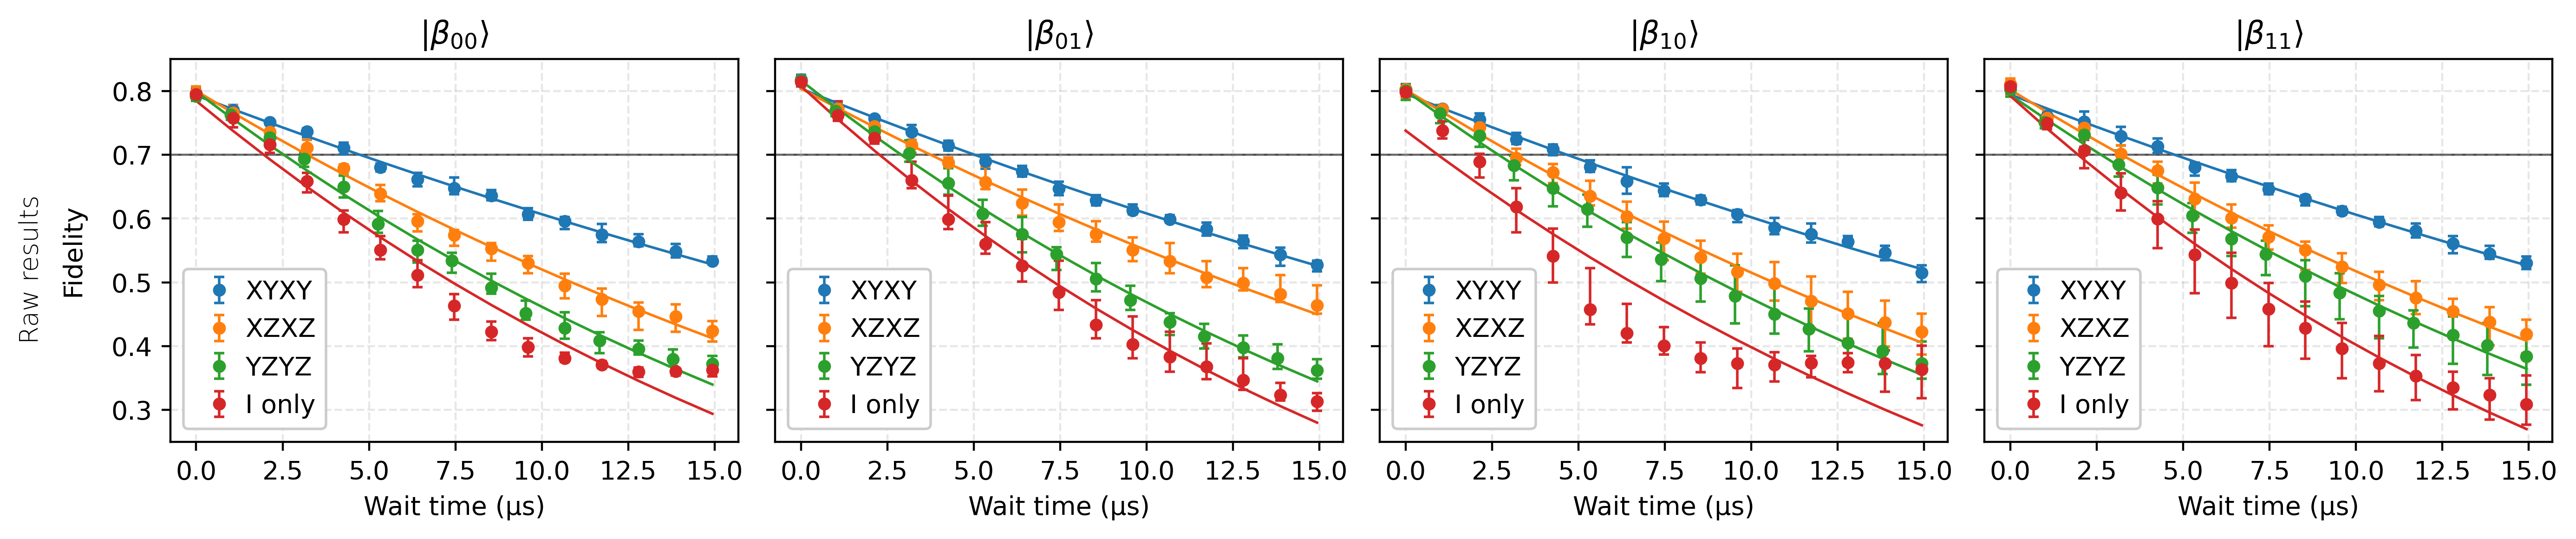

In [113]:
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

bell_labels = ["$|\\beta_{00}\\rangle$", "$|\\beta_{01}\\rangle$", "$|\\beta_{10}\\rangle$", "$|\\beta_{11}\\rangle$"]
wait_times = np.linspace(0, 15, 15)

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(14,3), constrained_layout=False, dpi=400)

axs[0].set_ylabel("Fidelity", labelpad=10)
msize = 4 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1 # Line width
elw = 1 # Error bar line width
a = 1 # Alpha
cs = 2 # Error bar cap size

for i in range(4): # For each state
        
    axs[i].set_title(bell_labels[i])
    axs[i].set_xlabel("Wait time (μs)")
    axs[i].set_ylim((0.25,0.85))
    axs[i].set_xlim((-0.7466666666666667, 15.68))

    # Get wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # Get the fidelities
    fidelity_XYXY = avg_counts00[i][0]/shots
    fidelity_XZXZ = avg_counts00[i][1]/shots
    fidelity_YZYZ = avg_counts00[i][2]/shots
    fidelity_IIII = avg_counts00[i][3]/shots
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts00[i][0]/shots)
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts00[i][0]/shots)
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts00[i][1]/shots)
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts00[i][1]/shots)
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts00[i][2]/shots)
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts00[i][2]/shots)
    min_err_IIII = np.abs(fidelity_IIII-min_counts00[i][3]/shots)
    max_err_IIII = np.abs(fidelity_IIII-max_counts00[i][3]/shots)
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts00[i][k]/shots
        state_times = all_wait_times[i][k]
        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=20, min=0)
        exp_model.set_param_hint('C', value=-0.1)
        fit_result = exp_model.fit(state_data, x=state_times)
        
        print(i, k, fit_result.params["T"])
        print("   ", fit_result.params["C"])
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))
        
    axs[i].axhline(0.7, lw=0.8, ls="solid", c="k", alpha=0.7, zorder=0)
    axs[i].legend(framealpha=1, loc="lower left", handletextpad=0)
    axs[i].grid(linestyle="--", alpha=0.3, zorder=0.1)

fig.supylabel("Raw results", x=0.015, fontweight="light", fontsize=10)
plt.tight_layout()
plt.show()
#plt.savefig(r"lima_4sequences_8192Shots_errorbars_10Reps_15us_15steps_13082022_fit_raw.pdf")  

**With measurement error mitigation and shifting**

Note: Run the cells above related to the error mitigation of the counts.

0 0 <Parameter 'T', value=45.37716489658551 +/- 0.853, bounds=[0:inf]>
    <Parameter 'C', value=-0.0007390237186475664 +/- 0.00283, bounds=[-inf:inf]>
0 1 <Parameter 'T', value=28.492240844428544 +/- 0.682, bounds=[0:inf]>
    <Parameter 'C', value=0.006855945793352542 +/- 0.00497, bounds=[-inf:inf]>
0 2 <Parameter 'T', value=21.8936366677273 +/- 0.86, bounds=[0:inf]>
    <Parameter 'C', value=0.007960293605059256 +/- 0.00944, bounds=[-inf:inf]>
0 3 <Parameter 'T', value=20.225954532756255 +/- 1.57, bounds=[0:inf]>
    <Parameter 'C', value=-0.0069237453575874885 +/- 0.0195, bounds=[-inf:inf]>
1 0 <Parameter 'T', value=42.94229210566437 +/- 0.845, bounds=[0:inf]>
    <Parameter 'C', value=-0.010848971786783875 +/- 0.00308, bounds=[-inf:inf]>
1 1 <Parameter 'T', value=32.087581320450255 +/- 0.789, bounds=[0:inf]>
    <Parameter 'C', value=-0.010674862583260116 +/- 0.00473, bounds=[-inf:inf]>
1 2 <Parameter 'T', value=21.063832666459742 +/- 0.474, bounds=[0:inf]>
    <Parameter 'C', val

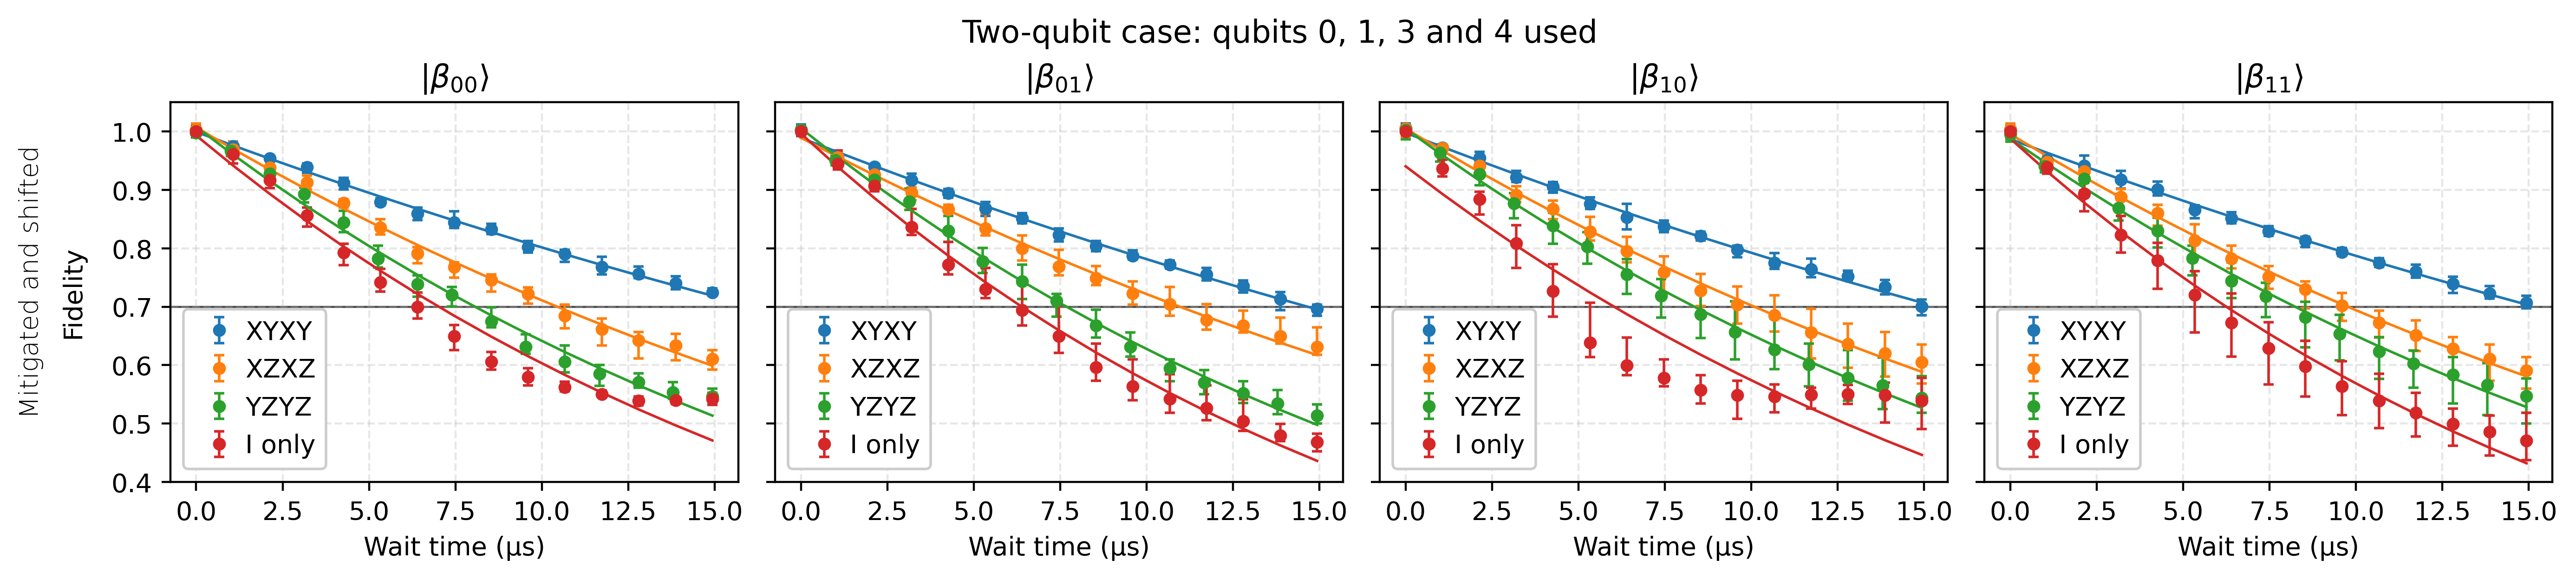

In [160]:
def exp_decay(x, T, C):
    return np.exp(-x/T) + C

bell_labels = ["$|\\beta_{00}\\rangle$", "$|\\beta_{01}\\rangle$", "$|\\beta_{10}\\rangle$", "$|\\beta_{11}\\rangle$"]
wait_times = np.linspace(0, 15, 15)
fidAfter2Swaps = []
corrections = []

fig, axs = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(14,3.3), constrained_layout=False, dpi=400)

axs[0].set_ylabel("Fidelity", labelpad=10)
msize = 4 # Markersize
msize_scatter = 10 # Markersize for scatter plots
medgewidth = 1 # Marker edge width
mtype = "o" # Marker type
mtype_scatter = "_" # Marker type in scatter plots
lw = 1 # Line width
elw = 1 # Error bar line width
a = 1 # Alpha
cs = 2 # Error bar cap size

Tvals = [[],[],[],[]]
Cvals = [[],[],[],[]]

for i in range(4): # For each state
        
    axs[i].set_title(bell_labels[i])
    axs[i].set_xlabel("Wait time (μs)")
    axs[i].set_ylim((0.4,1.05))
    axs[i].set_xlim((-0.7466666666666667, 15.68))
    
    # Get wait times
    t_XYXY = all_wait_times[i][0]
    t_XZXZ = all_wait_times[i][1]
    t_YZYZ = all_wait_times[i][2]
    t_IIII = all_wait_times[i][3]
    
    # For shifting the plots
    fidAfter2Swaps.append(avg_counts00[i][3][0]/shots)
    corrections.append(1-avg_counts00[i][3][0]/shots)
    
    # Get the fidelities
    fidelity_XYXY = avg_counts00[i][0]/shots + corrections[i]
    fidelity_XZXZ = avg_counts00[i][1]/shots + corrections[i]
    fidelity_YZYZ = avg_counts00[i][2]/shots + corrections[i]
    fidelity_IIII = avg_counts00[i][3]/shots + corrections[i]
    
    # For the error bar limits
    min_err_XYXY = np.abs(fidelity_XYXY-min_counts00[i][0]/shots-corrections[i])
    max_err_XYXY = np.abs(fidelity_XYXY-max_counts00[i][0]/shots-corrections[i])
    min_err_XZXZ = np.abs(fidelity_XZXZ-min_counts00[i][1]/shots-corrections[i])
    max_err_XZXZ = np.abs(fidelity_XZXZ-max_counts00[i][1]/shots-corrections[i])
    min_err_YZYZ = np.abs(fidelity_YZYZ-min_counts00[i][2]/shots-corrections[i])
    max_err_YZYZ = np.abs(fidelity_YZYZ-max_counts00[i][2]/shots-corrections[i])
    min_err_IIII = np.abs(fidelity_IIII-min_counts00[i][3]/shots-corrections[i])
    max_err_IIII = np.abs(fidelity_IIII-max_counts00[i][3]/shots-corrections[i])
    
    # Plot the data
    axs[i].errorbar(t_XYXY, fidelity_XYXY, yerr=[min_err_XYXY, max_err_XYXY],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C0",
                label="XYXY")
    axs[i].errorbar(t_XZXZ, fidelity_XZXZ, yerr=[min_err_XZXZ, max_err_XZXZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C1",
                label="XZXZ")
    axs[i].errorbar(t_YZYZ, fidelity_YZYZ, yerr=[min_err_YZYZ, max_err_YZYZ],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C2",
                label="YZYZ")
    axs[i].errorbar(t_IIII, fidelity_IIII, yerr=[min_err_IIII, max_err_IIII],
                linewidth=0, elinewidth=elw, capsize=cs,
                marker=mtype, markeredgewidth=medgewidth, markersize=msize, 
                alpha=a, c="C3",
                label="I only")
    
    # Plot the fits
    for k in range(4):
        state_data = avg_counts00[i][k]/shots + corrections[i]
        state_times = all_wait_times[i][k]

        exp_model = Model(exp_decay)
        exp_model.set_param_hint('T', value=20, min=0)
        exp_model.set_param_hint('C', value=-0.1)
        fit_result = exp_model.fit(state_data, x=state_times)
        print(i, k, fit_result.params["T"])
        print("   ", fit_result.params["C"])
        
        Tvals[i].append("$"+str(np.round(fit_result.params["T"].value,3)) + " \pm " + str(np.round(fit_result.params["T"].stderr,3))+"$")
        Cvals[i].append("$"+str(np.round(fit_result.params["C"].value,4)) + " \pm " + str(np.round(fit_result.params["C"].stderr,4))+"$")
        
        ploty = fit_result.best_fit
        axs[i].plot(state_times, ploty, linewidth=lw, alpha=a, c="C"+str(k))
        
    axs[i].axhline(0.7, lw=0.8, ls="solid", c="k", alpha=0.7, zorder=0)
    axs[i].legend(framealpha=1, loc="lower left", handletextpad=0)
    axs[i].grid(linestyle="--", alpha=0.3, zorder=0.1)

print()
print(fidAfter2Swaps)
print(corrections)

fig.suptitle("Two-qubit case: qubits 0, 1, 3 and 4 used", y=0.93)
fig.supylabel("Mitigated and shifted", x=0.015, fontweight="light", fontsize=10)

plt.tight_layout()
plt.show()
#plt.savefig(r"lima_4sequences_8192Shots_errorbars_10Reps_15us_15steps_12082022_fit_mitigated.pdf")  

In [161]:
# In LaTeX format
for i in range(4): # for each sequence
    t1, t2, t3, t4 = np.asarray(Tvals)[:,i]
    c1, c2, c3, c4 = np.asarray(Cvals)[:,i]
    print(t1, "&", t2, "&", t3, "&", t4, "\\\\")
    print(c1, "&", c2, "&", c3, "&", c4, "\\\\")

$45.377 \pm 0.853$ & $42.942 \pm 0.845$ & $43.497 \pm 0.914$ & $44.828 \pm 1.053$ \\
$-0.0007 \pm 0.0028$ & $-0.0108 \pm 0.0031$ & $-0.0023 \pm 0.0033$ & $-0.013 \pm 0.0036$ \\
$28.492 \pm 0.682$ & $32.088 \pm 0.789$ & $27.727 \pm 0.609$ & $27.88 \pm 0.552$ \\
$0.0069 \pm 0.005$ & $-0.0107 \pm 0.0047$ & $0.0049 \pm 0.0046$ & $-0.0046 \pm 0.0042$ \\
$21.894 \pm 0.86$ & $21.064 \pm 0.474$ & $22.975 \pm 0.476$ & $24.271 \pm 0.637$ \\
$0.008 \pm 0.0094$ & $0.0055 \pm 0.0055$ & $0.0048 \pm 0.0049$ & $-0.0123 \pm 0.006$ \\
$20.226 \pm 1.575$ & $18.165 \pm 0.717$ & $21.909 \pm 3.341$ & $18.399 \pm 0.832$ \\
$-0.0069 \pm 0.0195$ & $-0.0035 \pm 0.0104$ & $-0.0595 \pm 0.0367$ & $-0.0121 \pm 0.0118$ \\
